## This notebook is to compare effectiveness across four manual obfuscation strategies found in the Riddell-Juola corpus.

In [54]:
import os
import pickle
import chardet
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from functionwords import FunctionWords
from writeprints_static import WriteprintsStatic
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer, StandardScaler


import sys
sys.path.append('.')
from utilities import get_data_from_rj, get_data_from_ebg
# report

## 1. Grid search best svm params for EBG

In [5]:
# read in data
train_text_ebg, train_label_ebg, test_text_ebg_imi, test_label_ebg_imi = get_data_from_ebg('imitation')
_, _, test_text_ebg_obf, test_label_ebg_obf = get_data_from_ebg('obfuscation')

test_text_ebg  = test_text_ebg_imi + test_text_ebg_obf
test_label_ebg = test_label_ebg_imi + test_label_ebg_obf

In [6]:
# feature engineering
y_train_ebg = train_label_ebg
y_test_ebg = test_label_ebg

# writeprints static features
vec = WriteprintsStatic()
X_train_ebg_wps = vec.transform(train_text_ebg).toarray()
X_test_ebg_wps = vec.transform(test_text_ebg).toarray()

# koppel512 features
fw = FunctionWords(function_words_list='english')
X_train_ebg_koppel = np.array([fw.transform(raw) for raw in train_text_ebg])
X_test_ebg_koppel = np.array([fw.transform(raw) for raw in test_text_ebg])

In [27]:
# build a classifier
pipeline_svm = Pipeline([("normalizer", Normalizer(norm="l1")),
                     ("scaler", StandardScaler()),
                     ("Linear SVM", SVC(max_iter=-1, probability=True, break_ties=True,
                                       random_state=42))])




In [30]:
param_grid = {'kernel': ['linear', 'poly', 'rbf'],
              'C': np.power(10, np.arange(-5, 5, dtype=float)),
              'degree': np.linspace(1, 5, 5, dtype=int),
              'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
              'coef0': [0, 10, 100, 1000] }

In [52]:
search_results = []
for grid in list(ParameterGrid(param_grid))[:5]:
    search_result = {}
    pipeline_svm[2].set_params(**grid)
    pipeline_svm.fit(X_train_ebg_wps, y_train_ebg)
#     print(f'Accuray on test set is {pipeline_svm.score(X_test_ebg_wps, y_test_ebg)}')
    search_result['param'] = grid
    search_result['accuracy'] = pipeline_svm.score(X_test_ebg_wps, y_test_ebg)
    search_results.append(search_result)


In [57]:
pickle.dump(search_results, open('grid_search_ebg.pkl', 'wb'))

In [2]:
TASKS = [
    "imitation",
    "obfuscation",
    "control",
    "special_english"]

In [3]:
# read in data
train_text, train_label, test_text, test_label, treatment = [], [], [], [], []

for task in TASKS:
    _train_text, _train_label, _test_text, _test_label = get_data_from_rj(task)
    train_text.extend(_train_text)
    train_label.extend(_train_label)
    test_text.extend(_test_text)
    test_label.extend(_test_label)
    treatment.extend([task,]*len(_test_label))

In [4]:
# sanity check
assert len(test_label) == len(set(test_label))
print(f"total subjects: {len(test_label)}")

total subjects: 83


In [5]:
# feature engineering
y_train = train_label
y_test = test_label

# writeprints static features
vec = WriteprintsStatic()
X_train_wps = vec.transform(train_text).toarray()
X_test_wps = vec.transform(test_text).toarray()

# koppel512 features
fw = FunctionWords(function_words_list='english')
X_train_koppel = np.array([fw.transform(raw) for raw in train_text])
X_test_koppel = np.array([fw.transform(raw) for raw in test_text])

In [31]:
X_train_wps[3]

array([6.10000000e+02, 4.90327869e+00, 2.64000000e+02, 3.72700000e+03,
       0.00000000e+00, 1.63670512e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.72000000e+02,
       3.30000000e+01, 9.50000000e+01, 1.15000000e+02, 3.84000000e+02,
       5.10000000e+01, 6.20000000e+01, 1.49000000e+02, 2.08000000e+02,
       7.00000000e+00, 1.30000000e+01, 1.32000000e+02, 9.10000000e+01,
       2.27000000e+02, 2.02000000e+02, 6.00000000e+01, 5.00000000e+00,
       1.68000000e+02, 1.95000000e+02, 2.33000000e+02, 8.00000000e+01,
       4.20000000e+01, 3.60000000e+01, 8.00000000e+00, 5.80000000e+01,
       2.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [35]:
# ml pipelines
# standard linear SVM
pipeline_svm = Pipeline([("normalizer", Normalizer(norm="l1")),
                     ("scaler", StandardScaler()),
                     ("Linear SVM", SVC(C=1, kernel="linear", max_iter=-1, probability=True, break_ties=True,
                                       random_state=42))])
pipeline_svm.fit(X_train_wps, y_train)

# standard Logistic Regression
pipeline_lr = Pipeline([("normalizer", Normalizer(norm="l1")),
                     ("scaler", StandardScaler()),
                     ("Logistic regression", LogisticRegression(C=1, solver="lbfgs", max_iter=1e9))])
pipeline_lr.fit(X_train_koppel, y_train)

Pipeline(steps=[('normalizer', Normalizer(norm='l1')),
                ('scaler', StandardScaler()),
                ('Logistic regression',
                 LogisticRegression(C=1, max_iter=1000000000.0))])

In [36]:
# smv overall performance
pipeline_svm.score(X_test_wps, y_test)

0.07228915662650602

In [37]:
# lr overall performance
pipeline_lr.score(X_test_koppel, y_test)

0.07228915662650602

In [38]:
# author_proba = {y:None for y in y_test}
result_dict = {'author': [],
               'treatment': [],
               'proba_linearSVM(C1.0)+Writeprints_static': [],
               'proba_logisticReg(C1.0)+Koppel512': []}
label_idx = 0  # track treatment

for (X_wps, X_koppel, y) in zip(X_test_wps, X_test_koppel, y_test):
    _idx_svm = pipeline_svm.classes_.tolist().index(y)
    _proba_svm = pipeline_svm.predict_proba(X_wps.reshape(1, -1)).tolist()[0][_idx_svm]
    _idx_lr = pipeline_lr.classes_.tolist().index(y)
    _proba_lr = pipeline_lr.predict_proba(X_koppel.reshape(1, -1)).tolist()[0][_idx_lr]
    _treatment = treatment[label_idx]
    label_idx += 1
    result_dict['author'].append(y)
    result_dict['treatment'].append(_treatment)
    result_dict['proba_linearSVM(C1.0)+Writeprints_static'].append(_proba_svm)
    result_dict['proba_logisticReg(C1.0)+Koppel512'].append(_proba_lr)

In [39]:
df = pd.DataFrame.from_dict(result_dict)
df

author        treatment  proba_linearSVM(C1.0)+Writeprints_static  \
0   5f393f        imitation                                  0.001813   
1   2c5493        imitation                                  0.010138   
2   7c5ab3        imitation                                  0.027842   
3   1165b4        imitation                                  0.007249   
4   bade61        imitation                                  0.008806   
..     ...              ...                                       ...   
78  ddfb7e  special_english                                  0.011894   
79  ef8d1d  special_english                                  0.099565   
80  d78282  special_english                                  0.122279   
81  1eaf82  special_english                                  0.028012   
82  b17591  special_english                                  0.002176   

    proba_logisticReg(C1.0)+Koppel512  
0                            0.000078  
1                            0.149494  
2                            0.023593  
3                            0.001706  
4                            0.001809  
..                                ...  
78                           0.003630  
79                           0.087023  
80                           0.282682  
81                           0.029192  
82                           0.000980  

[83 rows x 4 columns]

In [10]:
df = pd.DataFrame.from_dict(result_dict)
df

author        treatment  proba_linearSVM(C1.0)+Writeprints_static  \
0   5f393f        imitation                                  0.001871   
1   2c5493        imitation                                  0.011157   
2   7c5ab3        imitation                                  0.032637   
3   1165b4        imitation                                  0.008006   
4   bade61        imitation                                  0.009007   
..     ...              ...                                       ...   
78  ddfb7e  special_english                                  0.012090   
79  ef8d1d  special_english                                  0.103878   
80  d78282  special_english                                  0.117604   
81  1eaf82  special_english                                  0.030311   
82  b17591  special_english                                  0.002157   

    proba_logisticReg(C1.0)+Koppel512  
0                            0.000078  
1                            0.149494  
2                            0.023593  
3                            0.001706  
4                            0.001809  
..                                ...  
78                           0.003630  
79                           0.087023  
80                           0.282682  
81                           0.029192  
82                           0.000980  

[83 rows x 4 columns]

In [25]:
df.loc[df['proba_linearSVM(C1.0)+Writeprints_static'] > 0.02]

author        treatment  proba_linearSVM(C1.0)+Writeprints_static  \
2   7c5ab3        imitation                                  0.032637   
7   3f5fcd        imitation                                  0.083680   
8   20a782        imitation                                  0.024447   
10  3b79ad        imitation                                  0.046036   
11  320392        imitation                                  0.028193   
15  7e5890        imitation                                  0.066322   
17  e7ea00      obfuscation                                  0.051246   
18  59db82      obfuscation                                  0.041352   
21  1b7827      obfuscation                                  0.027942   
23  b17b9d      obfuscation                                  0.021234   
27  b2f054      obfuscation                                  0.042129   
40  d50ff5      obfuscation                                  0.174339   
48  8ec2f0          control                                  0.059895   
49  8c70d4          control                                  0.107716   
53  afcd47          control                                  0.086103   
54  f787de          control                                  0.057501   
55  cfe6f9          control                                  0.035656   
62  81f6d4          control                                  0.023316   
64  0bea01          control                                  0.044679   
65  b52fbc  special_english                                  0.042521   
66  d665f1  special_english                                  0.084434   
70  bb5bcd  special_english                                  0.053770   
75  4c5eca  special_english                                  0.218919   
77  1d6902  special_english                                  0.145504   
79  ef8d1d  special_english                                  0.103878   
80  d78282  special_english                                  0.117604   
81  1eaf82  special_english                                  0.030311   

    proba_logisticReg(C1.0)+Koppel512  
2                            0.023593  
7                            0.000005  
8                            0.001839  
10                           0.005106  
11                           0.022490  
15                           0.246843  
17                           0.000062  
18                           0.357173  
21                           0.012159  
23                           0.000819  
27                           0.117589  
40                           0.009485  
48                           0.007873  
49                           0.344458  
53                           0.078735  
54                           0.130426  
55                           0.007334  
62                           0.002062  
64                           0.007284  
65                           0.022073  
66                           0.186737  
70                           0.106753  
75                           0.637284  
77                           0.002402  
79                           0.087023  
80                           0.282682  
81                           0.029192

<AxesSubplot:xlabel='proba_linearSVM(C1.0)+Writeprints_static', ylabel='proba_logisticReg(C1.0)+Koppel512'>

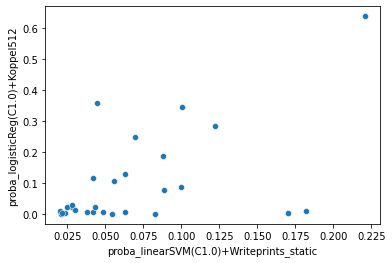

In [40]:
import seaborn as sns

sns.scatterplot(x='proba_linearSVM(C1.0)+Writeprints_static',
         y='proba_logisticReg(C1.0)+Koppel512',
         data=df.loc[df['proba_linearSVM(C1.0)+Writeprints_static'] > 0.02])



In [11]:
# df.to_csv('result.csv', index=False)

[end]

In [21]:
df_ = pd.read_csv('result.csv')

In [22]:
df_

author        treatment  proba_linearSVM(C1.0)+Writeprints_static  \
0   5f393f        imitation                                  0.001813   
1   2c5493        imitation                                  0.011331   
2   7c5ab3        imitation                                  0.029252   
3   1165b4        imitation                                  0.007387   
4   bade61        imitation                                  0.009252   
..     ...              ...                                       ...   
78  ddfb7e  special_english                                  0.011915   
79  ef8d1d  special_english                                  0.102774   
80  d78282  special_english                                  0.121559   
81  1eaf82  special_english                                  0.025501   
82  b17591  special_english                                  0.002092   

    proba_logisticReg(C1.0)+Koppel512  
0                            0.000078  
1                            0.149494  
2                            0.023593  
3                            0.001706  
4                            0.001809  
..                                ...  
78                           0.003630  
79                           0.087023  
80                           0.282682  
81                           0.029192  
82                           0.000980  

[83 rows x 4 columns]

In [14]:
df.groupby(by=['treatment']).describe().round(3)

proba_linearSVM(C1.0)+Writeprints_static                       \
                                                   count   mean    std    min   
treatment                                                                       
control                                             21.0  0.024  0.030  0.000   
imitation                                           17.0  0.022  0.024  0.002   
obfuscation                                         27.0  0.018  0.034  0.001   
special_english                                     18.0  0.049  0.062  0.001   

                                            proba_logisticReg(C1.0)+Koppel512  \
                   25%    50%    75%    max                             count   
treatment                                                                       
control          0.004  0.011  0.036  0.108                              21.0   
imitation        0.007  0.011  0.028  0.084                              17.0   
obfuscation      0.002  0.009  0.019  0.174                              27.0   
special_english  0.004  0.018  0.077  0.219                              18.0   

                                                                
                  mean    std  min    25%    50%    75%    max  
treatment                                                       
control          0.034  0.080  0.0  0.000  0.003  0.008  0.344  
imitation        0.030  0.066  0.0  0.001  0.002  0.022  0.247  
obfuscation      0.021  0.071  0.0  0.000  0.002  0.009  0.357  
special_english  0.078  0.160  0.0  0.001  0.009  0.073  0.637

In [15]:
1/83

0.012048192771084338